# DAX Daily Direction: Continuation vs Mean-Reversion
## Does Yesterday's Daily Move Predict Today's Direction?

**Objective:** Test whether yesterday's daily return (direction + magnitude, normalized by volatility) predicts today's intraday return direction and size, and how this depends on volatility regime.

**Key Question:**
- If yesterday was an up day (especially a big up day), is today more likely to continue up or reverse down?
- Does this depend on volatility regime (High vol acts differently from Low vol)?
- Can we use yesterday's price action to set directional bias for today?

**Hypothesis:**
- H0: Yesterday's return direction/size and today's return are independent; P(continuation) ≈ 50%
- H1: Patterns exist (continuation or reversal depending on size and regime)

**Data:** M5 OHLCV bars, Jan 2023 – Sept 2025, UTC → Berlin time (pytz auto DST), RTH only (09:00-17:30)

**Critical Constraint:** At end of day D, we know:
- Yesterday's (D-1) return (fully completed)
- Yesterday's (D-1) regime (fully completed)

We do NOT know:
- Today's (D) return (in progress during day)
- Today's (D) regime (will know at close)

This is purely forward-looking: "Given yesterday closed X, predict today's behavior."

---


## Part 1: Data Preparation and Daily Metrics


In [1]:
import sys
sys.path.insert(0, '../../')

from shared.database_connector import fetch_ohlcv, get_date_range
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

print('[OK] Dependencies loaded')
print('='*80)

[OK] Dependencies loaded


## Step 1: Fetch M5 Data and Calculate Daily Returns


In [2]:
print('\n[STEP 1] Fetch M5 Data and Calculate Daily Returns')
print('='*80)

# Get available date range
date_range = get_date_range('deuidxeur', 'm5')
end_date = date_range['end']
start_date = end_date - timedelta(days=730)  # ~2 years

print(f'Fetching M5 data: {start_date.date()} to {end_date.date()}')

# Fetch M5 data
df_raw = fetch_ohlcv(
    symbol='deuidxeur',
    timeframe='m5',
    start_date=start_date,
    end_date=end_date
)

# Convert to Berlin time (pytz handles DST automatically)
df = df_raw.copy()
df.index = df.index.tz_convert('Europe/Berlin')

print(f'[OK] Fetched {len(df)} M5 candles')

# Extract time components
df['date'] = df.index.date
df['hour'] = df.index.hour
df['minute'] = df.index.minute

# Filter to RTH (09:00-17:30 Berlin time)
df_rth = df[(df['hour'] >= 9) & ((df['hour'] < 17) | ((df['hour'] == 17) & (df['minute'] <= 30)))].copy()

print(f'[OK] Filtered to RTH (09:00-17:30): {len(df_rth)} candles')

# Calculate True Range for each M5 bar
df_rth['c_prev'] = df_rth['close'].shift(1)
day_boundary = df_rth['date'] != df_rth['date'].shift(1)
df_rth.loc[day_boundary, 'c_prev'] = np.nan

df_rth['hl_range'] = df_rth['high'] - df_rth['low']
df_rth['h_cp_range'] = (df_rth['high'] - df_rth['c_prev']).abs()
df_rth['l_cp_range'] = (df_rth['low'] - df_rth['c_prev']).abs()
df_rth['tr'] = df_rth[['hl_range', 'h_cp_range', 'l_cp_range']].max(axis=1)
df_rth.loc[day_boundary, 'tr'] = df_rth.loc[day_boundary, 'hl_range']

print(f'[OK] Calculated True Range for all M5 bars')

2025-11-29 14:29:03,024 - shared.database_connector - INFO - Initializing database connection...
2025-11-29 14:29:03,024 - shared.database_connector - WARNING - CA certificate not found at certs\ca-certificate.crt. Connecting without SSL verification.



[STEP 1] Fetch M5 Data and Calculate Daily Returns


2025-11-29 14:29:03,723 - shared.database_connector - INFO - [OK] Database connection successful
2025-11-29 14:29:03,995 - shared.database_connector - INFO - [OK] Date range for deuidxeur m5: 2023-01-08 23:00:00+00:00 to 2025-09-16 21:55:00+00:00
2025-11-29 14:29:03,996 - shared.database_connector - INFO - fetch_ohlcv(): symbol=deuidxeur, timeframe=m5, start=2023-09-17 21:55:00+00:00, end=2025-09-16 21:55:00+00:00


Fetching M5 data: 2023-09-17 to 2025-09-16


2025-11-29 14:29:05,414 - shared.database_connector - INFO - [OK] Fetched 136661 candles (2023-09-17 21:55:00+00:00 to 2025-09-16 21:55:00+00:00)


[OK] Fetched 136661 M5 candles
[OK] Filtered to RTH (09:00-17:30): 53005 candles
[OK] Calculated True Range for all M5 bars


## Step 2: Aggregate to Daily Level (Open to Close Returns and Regimes)


In [3]:
print('\n[STEP 2] Aggregate to Daily Level')
print('='*80)

daily_data = []

for date, day_data in df_rth.groupby('date'):
    if len(day_data) < 12:  # Need at least 1 hour of data
        continue
    
    daily_open = day_data.iloc[0]['open']
    daily_close = day_data.iloc[-1]['close']
    daily_tr_sum = day_data['tr'].sum()
    atrp = (daily_tr_sum / daily_close) * 100 if daily_close > 0 else 0
    
    # Daily return in %
    daily_return = (daily_close / daily_open - 1) * 100 if daily_open > 0 else 0
    
    row = {
        'date': date,
        'daily_open': daily_open,
        'daily_close': daily_close,
        'daily_return': daily_return,
        'daily_tr_sum': daily_tr_sum,
        'atrp': atrp,
        'n_bars': len(day_data),
    }
    daily_data.append(row)

df_daily = pd.DataFrame(daily_data).sort_values('date').reset_index(drop=True)

print(f'[OK] Aggregated to {len(df_daily)} trading days')
print(f'Date range: {df_daily["date"].min()} to {df_daily["date"].max()}')

# Calculate volatility regimes using 60-day rolling percentile (no look-ahead)
def rolling_percentile_rank(series, window=61):
    """Calculate percentile rank with no look-ahead bias."""
    ranks = []
    for i in range(len(series)):
        if i < window - 1:
            ranks.append(np.nan)
        else:
            prior_window = series.iloc[i - window + 1: i].values
            current_value = series.iloc[i]
            rank = stats.percentileofscore(prior_window, current_value)
            ranks.append(rank)
    return ranks

df_daily['atrp_percentile_rank'] = rolling_percentile_rank(df_daily['atrp'], window=61)

def label_regime(percentile):
    if pd.isna(percentile):
        return 'Unknown'
    elif percentile < 33.33:
        return 'Low'
    elif percentile < 66.67:
        return 'Normal'
    else:
        return 'High'

df_daily['regime'] = df_daily['atrp_percentile_rank'].apply(label_regime)

# Filter to valid regimes
df_daily_valid = df_daily[df_daily['regime'] != 'Unknown'].reset_index(drop=True)

print(f'\n[OK] Assigned regimes (60-day rolling percentile, no look-ahead)')
print(f'Valid regime days: {len(df_daily_valid)}')

print(f'\nDaily Return Statistics:')
print(f'  Mean: {df_daily_valid["daily_return"].mean():+.3f}%')
print(f'  Std: {df_daily_valid["daily_return"].std():.3f}%')
print(f'  Min: {df_daily_valid["daily_return"].min():+.3f}%')
print(f'  Max: {df_daily_valid["daily_return"].max():+.3f}%')


[STEP 2] Aggregate to Daily Level
[OK] Aggregated to 515 trading days
Date range: 2023-09-18 to 2025-09-16

[OK] Assigned regimes (60-day rolling percentile, no look-ahead)
Valid regime days: 455

Daily Return Statistics:
  Mean: +0.028%
  Std: 0.729%
  Min: -3.546%
  Max: +7.029%


## Step 3: Direction and Size Features (Relative, Normalized)


In [4]:
print('\n[STEP 3] Calculate Direction and Relative Size Features')
print('='*80)

# Direction of daily return
df_daily_valid['direction'] = np.sign(df_daily_valid['daily_return'])

# Absolute return
df_daily_valid['abs_daily_return'] = df_daily_valid['daily_return'].abs()

# Normalize by 20-day rolling average (using only past data, no look-ahead)
df_daily_valid['mean_abs_return_20'] = df_daily_valid['abs_daily_return'].rolling(
    window=20, min_periods=5
).mean()

# Relative return (dimensionless, normalized by recent volatility)
df_daily_valid['daily_return_rel'] = df_daily_valid['daily_return'] / (
    df_daily_valid['mean_abs_return_20'].clip(lower=0.01)  # Avoid /0
)

# Classify move type by direction and magnitude
def classify_move(return_rel):
    if return_rel > 1.0:
        return 'Strong Up'
    elif return_rel > 0:
        return 'Mild Up'
    elif return_rel > -1.0:
        return 'Mild Down'
    else:
        return 'Strong Down'

df_daily_valid['move_type'] = df_daily_valid['daily_return_rel'].apply(classify_move)

print(f'[OK] Calculated direction and relative size features')

print(f'\nMove Type Distribution:')
for move_type in ['Strong Up', 'Mild Up', 'Mild Down', 'Strong Down']:
    count = (df_daily_valid['move_type'] == move_type).sum()
    pct = count / len(df_daily_valid) * 100
    print(f'  {move_type:12} {count:3d} days ({pct:5.1f}%)')

print(f'\nSample data:')
sample_cols = ['date', 'daily_return', 'direction', 'daily_return_rel', 'move_type', 'regime']
print(df_daily_valid[sample_cols].head(30).to_string(index=False))


[STEP 3] Calculate Direction and Relative Size Features
[OK] Calculated direction and relative size features

Move Type Distribution:
  Strong Up    101 days ( 22.2%)
  Mild Up      146 days ( 32.1%)
  Mild Down    118 days ( 25.9%)
  Strong Down   90 days ( 19.8%)

Sample data:
      date  daily_return  direction  daily_return_rel   move_type regime
2023-12-11      0.458710        1.0               NaN Strong Down    Low
2023-12-12     -0.081210       -1.0               NaN Strong Down    Low
2023-12-13     -0.481682       -1.0               NaN Strong Down    Low
2023-12-14     -0.870669       -1.0               NaN Strong Down   High
2023-12-15     -0.549384       -1.0         -1.125024 Strong Down Normal
2023-12-18     -0.320576       -1.0         -0.696341   Mild Down    Low
2023-12-19      0.376769        1.0          0.840198     Mild Up    Low
2023-12-20      0.000179        1.0          0.000456     Mild Up    Low
2023-12-21     -0.052427       -1.0         -0.147838   Mild D

## Step 4: Create Day Pairs (Today's Move → Tomorrow's Direction)


In [5]:
print('\n[STEP 4] Create Day Pairs (Yesterday → Today Predictions)')
print('='*80)

# Create "next day" columns by shifting backward
# At end of day D, we know day D's full return
# We want to predict day D+1's return
df_daily_valid['return_next'] = df_daily_valid['daily_return'].shift(-1)
df_daily_valid['direction_next'] = df_daily_valid['direction'].shift(-1)
df_daily_valid['regime_next'] = df_daily_valid['regime'].shift(-1)

# Drop last day (no next day in sample)
df_pairs = df_daily_valid[df_daily_valid['direction_next'].notna()].copy()

print(f'[OK] Created {len(df_pairs)} day pairs (today → tomorrow)')
print(f'First pair: {df_pairs.iloc[0]["date"]} ({df_pairs.iloc[0]["direction"]:+.0f}) → {df_pairs.iloc[1]["date"]} ({df_pairs.iloc[1]["direction"]:+.0f})')
print(f'Last pair: {df_pairs.iloc[-2]["date"]} → {df_pairs.iloc[-1]["date"]}')

# Define continuation and reversal
df_pairs['is_continuation'] = (np.sign(df_pairs['direction']) == np.sign(df_pairs['direction_next'])).astype(int)
df_pairs['is_reversal'] = (np.sign(df_pairs['direction']) == -np.sign(df_pairs['direction_next'])).astype(int)

print(f'\n[Continuation vs Reversal]')
cont_count = df_pairs['is_continuation'].sum()
rev_count = df_pairs['is_reversal'].sum()
neutral = len(df_pairs) - cont_count - rev_count
print(f'  Continuation: {cont_count} days ({cont_count/len(df_pairs)*100:.1f}%)')
print(f'  Reversal: {rev_count} days ({rev_count/len(df_pairs)*100:.1f}%)')
print(f'  Neutral (dir 0→?): {neutral} days')


[STEP 4] Create Day Pairs (Yesterday → Today Predictions)
[OK] Created 454 day pairs (today → tomorrow)
First pair: 2023-12-11 (+1) → 2023-12-12 (-1)
Last pair: 2025-09-12 → 2025-09-15

[Continuation vs Reversal]
  Continuation: 225 days (49.6%)
  Reversal: 229 days (50.4%)
  Neutral (dir 0→?): 0 days


## Step 5: Global Continuation vs Reversal Rate


In [6]:
print('\n[STEP 5] Global Continuation vs Reversal Rate')
print('='*80)

# Filter to days with directional moves (exclude near-zero direction)
df_directional = df_pairs[df_pairs['direction'] != 0].copy()

print(f'\nDays with non-zero direction: {len(df_directional)} / {len(df_pairs)}')

# Global rates
p_cont_global = df_directional['is_continuation'].sum() / len(df_directional) if len(df_directional) > 0 else 0
p_rev_global = df_directional['is_reversal'].sum() / len(df_directional) if len(df_directional) > 0 else 0
p_neutral = (len(df_directional) - df_directional['is_continuation'].sum() - df_directional['is_reversal'].sum()) / len(df_directional) if len(df_directional) > 0 else 0

print(f'\n[GLOBAL RATES (All Days)]')
print(f'  P(Continuation | dir != 0) = {p_cont_global:.1%}')
print(f'  P(Reversal | dir != 0) = {p_rev_global:.1%}')
print(f'  P(Neutral next) = {p_neutral:.1%}')
print(f'  Total: {p_cont_global + p_rev_global + p_neutral:.1%} (should be 100%)')

# Statistical test: Is continuation significantly different from 50%?
print(f'\n[BINOMIAL TEST] H0: P(cont) = 0.5 (no edge)')
print(f'H1: P(cont) ≠ 0.5 (edge exists)\n')

n_cont = df_directional['is_continuation'].sum()
n_total = len(df_directional)

binom_result = stats.binomtest(n_cont, n_total, 0.5, alternative='two-sided')
binom_pval = binom_result.pvalue

print(f'Continuation count: {n_cont} / {n_total}')
print(f'Observed rate: {p_cont_global:.4f}')
print(f'Expected under H0: 0.5000')
print(f'p-value: {binom_pval:.4f}')
print(f'\nConclusion: {"SIGNIFICANT" if binom_pval < 0.05 else "NOT SIGNIFICANT"}' +
      f' at p<0.05\n')

if binom_pval < 0.05:
    if p_cont_global > 0.5:
        print(f'→ MOMENTUM bias: Continuation ({p_cont_global:.1%}) > Reversal ({p_rev_global:.1%})')
    else:
        print(f'→ MEAN-REVERSION bias: Reversal ({p_rev_global:.1%}) > Continuation ({p_cont_global:.1%})')
else:
    print(f'→ NO UNCONDITIONAL EDGE: Continuation ≈ Reversal ≈ 50%')
    print(f'→ Must condition on regime or move size for patterns')


[STEP 5] Global Continuation vs Reversal Rate

Days with non-zero direction: 454 / 454

[GLOBAL RATES (All Days)]
  P(Continuation | dir != 0) = 49.6%
  P(Reversal | dir != 0) = 50.4%
  P(Neutral next) = 0.0%
  Total: 100.0% (should be 100%)

[BINOMIAL TEST] H0: P(cont) = 0.5 (no edge)
H1: P(cont) ≠ 0.5 (edge exists)

Continuation count: 225 / 454
Observed rate: 0.4956
Expected under H0: 0.5000
p-value: 0.8881

Conclusion: NOT SIGNIFICANT at p<0.05

→ NO UNCONDITIONAL EDGE: Continuation ≈ Reversal ≈ 50%
→ Must condition on regime or move size for patterns


## Step 6: Continuation vs Reversal by Move Type


In [7]:
print('\n[STEP 6] Continuation vs Reversal by Move Type (Size + Direction)')
print('='*80)

# Analyze each move type
results_by_move = []

print(f'\n{"Move Type":<15} {"N":>5} {"Cont":>8} {"Rev":>8} {"Mean Next":>12} {"Pattern":20}')
print(f'{"="*15} {"="*5} {"="*8} {"="*8} {"="*12} {"="*20}')

for move_type in ['Strong Up', 'Mild Up', 'Mild Down', 'Strong Down']:
    move_data = df_directional[df_directional['move_type'] == move_type]
    
    if len(move_data) < 5:
        continue
    
    n = len(move_data)
    cont = move_data['is_continuation'].sum()
    rev = move_data['is_reversal'].sum()
    p_cont = cont / n if n > 0 else 0
    p_rev = rev / n if n > 0 else 0
    
    mean_next = move_data['return_next'].mean()
    
    # Determine pattern
    if p_cont > 0.6:
        pattern = 'MOMENTUM'
    elif p_rev > 0.6:
        pattern = 'MEAN-REVERSION'
    else:
        pattern = 'MIXED'
    
    print(f'{move_type:<15} {n:>5d} {p_cont*100:>7.0f}% {p_rev*100:>7.0f}% {mean_next:>+11.3f}% {pattern:20}')
    
    results_by_move.append({
        'move_type': move_type,
        'n': n,
        'p_cont': p_cont,
        'p_rev': p_rev,
        'mean_next': mean_next,
        'pattern': pattern,
    })

df_results_move = pd.DataFrame(results_by_move)


[STEP 6] Continuation vs Reversal by Move Type (Size + Direction)

Move Type           N     Cont      Rev    Mean Next Pattern             
=============== ===== ======== ======== ============ ====================
Strong Up         101      55%      45%      -0.030% MIXED               
Mild Up           146      53%      47%      +0.027% MIXED               
Mild Down         118      45%      55%      +0.057% MIXED               
Strong Down        89      44%      56%      +0.051% MIXED               


## Step 7: Continuation vs Reversal by Volatility Regime


In [8]:
print('\n[STEP 7] Continuation vs Reversal by Volatility Regime')
print('='*80)

results_by_regime = []

for regime in ['Low', 'Normal', 'High']:
    regime_data = df_directional[df_directional['regime'] == regime]
    
    if len(regime_data) == 0:
        continue
    
    print(f'\n\n{regime.upper()} VOLATILITY REGIME ({len(regime_data)} days):')
    print('-' * 90)
    
    print(f'\n{"Move Type":<15} {"N":>5} {"Cont":>8} {"Rev":>8} {"Mean Next":>12} {"Sig?":>6}')
    print(f'{"="*15} {"="*5} {"="*8} {"="*8} {"="*12} {"="*6}')
    
    for move_type in ['Strong Up', 'Mild Up', 'Mild Down', 'Strong Down']:
        move_regime_data = regime_data[regime_data['move_type'] == move_type]
        
        if len(move_regime_data) < 5:
            continue
        
        n = len(move_regime_data)
        cont = move_regime_data['is_continuation'].sum()
        rev = move_regime_data['is_reversal'].sum()
        p_cont = cont / n if n > 0 else 0
        p_rev = rev / n if n > 0 else 0
        
        mean_next = move_regime_data['return_next'].mean()
        
        # Binomial test
        if cont + rev >= 5:
            binom_res = stats.binomtest(cont, cont + rev, 0.5, alternative='two-sided')
            is_sig = 'YES' if binom_res.pvalue < 0.05 else 'NO'
        else:
            is_sig = 'N/A'
        
        print(f'{move_type:<15} {n:>5d} {p_cont*100:>7.0f}% {p_rev*100:>7.0f}% {mean_next:>+11.3f}% {is_sig:>6}')
        
        results_by_regime.append({
            'regime': regime,
            'move_type': move_type,
            'n': n,
            'p_cont': p_cont,
            'p_rev': p_rev,
            'mean_next': mean_next,
        })

df_results_regime = pd.DataFrame(results_by_regime)


[STEP 7] Continuation vs Reversal by Volatility Regime


LOW VOLATILITY REGIME (167 days):
------------------------------------------------------------------------------------------

Move Type           N     Cont      Rev    Mean Next   Sig?
=============== ===== ======== ======== ============ ======
Strong Up          39      51%      49%      -0.079%     NO
Mild Up            67      55%      45%      +0.042%     NO
Mild Down          46      50%      50%      -0.020%     NO
Strong Down        15      40%      60%      -0.014%     NO


NORMAL VOLATILITY REGIME (141 days):
------------------------------------------------------------------------------------------

Move Type           N     Cont      Rev    Mean Next   Sig?
=============== ===== ======== ======== ============ ======
Strong Up          35      54%      46%      +0.066%     NO
Mild Up            49      53%      47%      -0.017%     NO
Mild Down          36      44%      56%      +0.091%     NO
Strong Down        21    

## Step 8: Combination Analysis (Move Type × Regime)


In [9]:
print('\n[STEP 8] Combination: Move Type × Regime Matrix')
print('='*80)

print(f'''\n[SUMMARY TABLE] Yesterday's Move Type + Today's Regime → Continuation Probability

Rows: Yesterday's Move Type (Strong/Mild Up/Down)
Columns: Today's Volatility Regime (Low/Normal/High)
Values: P(Today continues yesterday's direction)

''')

# Create pivot table
pivot_data = []

for move_type in ['Strong Up', 'Mild Up', 'Mild Down', 'Strong Down']:
    row = {'move_type': move_type}
    
    for regime in ['Low', 'Normal', 'High']:
        subset = df_directional[
            (df_directional['move_type'] == move_type) & 
            (df_directional['regime'] == regime)
        ]
        
        if len(subset) >= 5:
            p_cont = subset['is_continuation'].sum() / len(subset)
            row[regime] = f'{p_cont:.1%} ({len(subset)}d)'
        else:
            row[regime] = f'N/A ({len(subset)}d)'
    
    pivot_data.append(row)

df_pivot = pd.DataFrame(pivot_data)
print(df_pivot.to_string(index=False))

print(f'''

Interpretation:
- Values > 55%: Slight continuation bias
- Values around 50%: No bias (independent)
- Values < 45%: Reversal bias

Look for patterns like:
- "Strong Up in High regime → 70% continuation" (clear momentum)
- "Strong Up in Low regime → 40% continuation" (reversal tendency)
''')


[STEP 8] Combination: Move Type × Regime Matrix

[SUMMARY TABLE] Yesterday's Move Type + Today's Regime → Continuation Probability

Rows: Yesterday's Move Type (Strong/Mild Up/Down)
Columns: Today's Volatility Regime (Low/Normal/High)
Values: P(Today continues yesterday's direction)


  move_type         Low      Normal        High
  Strong Up 51.3% (39d) 54.3% (35d) 63.0% (27d)
    Mild Up 55.2% (67d) 53.1% (49d) 46.7% (30d)
  Mild Down 50.0% (46d) 44.4% (36d) 38.9% (36d)
Strong Down 40.0% (15d) 42.9% (21d) 45.3% (53d)


Interpretation:
- Values > 55%: Slight continuation bias
- Values around 50%: No bias (independent)
- Values < 45%: Reversal bias

Look for patterns like:
- "Strong Up in High regime → 70% continuation" (clear momentum)
- "Strong Up in Low regime → 40% continuation" (reversal tendency)



## Step 9: Visualizations



[STEP 9] Visualizations


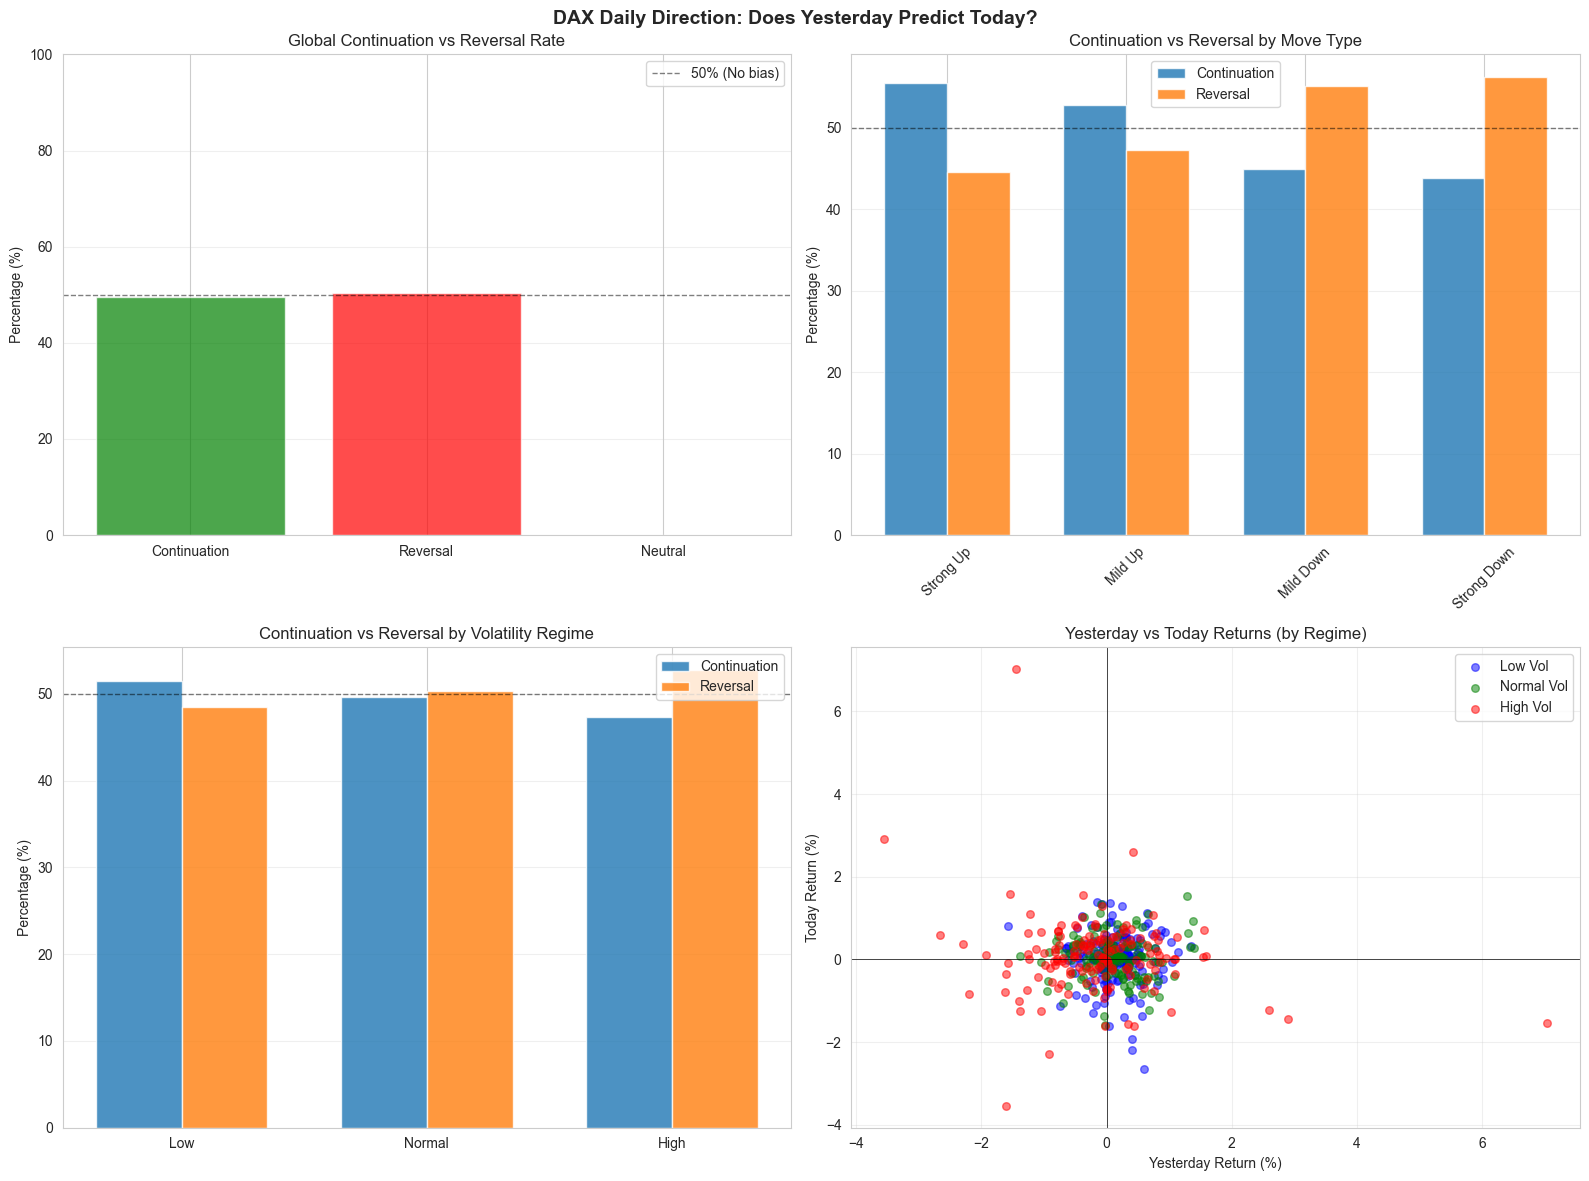

[OK] Visualizations created


In [10]:
print('\n[STEP 9] Visualizations')
print('='*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('DAX Daily Direction: Does Yesterday Predict Today?', 
             fontsize=14, fontweight='bold')

# Plot 1: Global continuation rate
ax = axes[0, 0]
categories = ['Continuation', 'Reversal', 'Neutral']
values = [
    df_directional['is_continuation'].sum() / len(df_directional) * 100,
    df_directional['is_reversal'].sum() / len(df_directional) * 100,
    (len(df_directional) - df_directional['is_continuation'].sum() - df_directional['is_reversal'].sum()) / len(df_directional) * 100
]
colors = ['green', 'red', 'gray']
ax.bar(categories, values, color=colors, alpha=0.7)
ax.axhline(y=50, color='black', linestyle='--', linewidth=1, alpha=0.5, label='50% (No bias)')
ax.set_ylabel('Percentage (%)')
ax.set_title('Global Continuation vs Reversal Rate')
ax.set_ylim([0, 100])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Plot 2: By move type
ax = axes[0, 1]
if len(df_results_move) > 0:
    x = np.arange(len(df_results_move))
    width = 0.35
    ax.bar(x - width/2, df_results_move['p_cont'] * 100, width, label='Continuation', alpha=0.8)
    ax.bar(x + width/2, df_results_move['p_rev'] * 100, width, label='Reversal', alpha=0.8)
    ax.axhline(y=50, color='black', linestyle='--', linewidth=1, alpha=0.5)
    ax.set_xticks(x)
    ax.set_xticklabels(df_results_move['move_type'], rotation=45)
    ax.set_ylabel('Percentage (%)')
    ax.set_title('Continuation vs Reversal by Move Type')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

# Plot 3: By regime
ax = axes[1, 0]
regimes = ['Low', 'Normal', 'High']
cont_by_regime = []
rev_by_regime = []

for regime in regimes:
    regime_data = df_directional[df_directional['regime'] == regime]
    if len(regime_data) > 0:
        cont_by_regime.append(regime_data['is_continuation'].sum() / len(regime_data) * 100)
        rev_by_regime.append(regime_data['is_reversal'].sum() / len(regime_data) * 100)
    else:
        cont_by_regime.append(0)
        rev_by_regime.append(0)

x = np.arange(len(regimes))
width = 0.35
ax.bar(x - width/2, cont_by_regime, width, label='Continuation', alpha=0.8)
ax.bar(x + width/2, rev_by_regime, width, label='Reversal', alpha=0.8)
ax.axhline(y=50, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xticks(x)
ax.set_xticklabels(regimes)
ax.set_ylabel('Percentage (%)')
ax.set_title('Continuation vs Reversal by Volatility Regime')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Plot 4: Scatter of yesterday return vs today return
ax = axes[1, 1]
colors_regime = {'Low': 'blue', 'Normal': 'green', 'High': 'red'}
for regime in ['Low', 'Normal', 'High']:
    regime_data = df_directional[df_directional['regime'] == regime]
    ax.scatter(regime_data['daily_return'], regime_data['return_next'],
              alpha=0.5, s=30, color=colors_regime[regime], label=f'{regime} Vol')

ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.set_xlabel('Yesterday Return (%)')
ax.set_ylabel('Today Return (%)')
ax.set_title('Yesterday vs Today Returns (by Regime)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('[OK] Visualizations created')

## Step 10: Summary and Trading Implications


In [11]:
print('\n[STEP 10] Summary and Trading Implications')
print('='*80)

print(f'''
[DAILY DIRECTION CONTINUATION vs MEAN-REVERSION - SUMMARY]

1. GLOBAL PATTERN:

   Without conditioning on anything:
   - P(Continuation) = {p_cont_global:.1%}
   - P(Reversal) = {p_rev_global:.1%}
   - P(Neutral next) = {p_neutral:.1%}
   
   Is this significantly different from 50/50?
   Binomial test: p-value = {binom_pval:.4f}
   
   Interpretation:
   {"→ YES: Statistically significant continuation or reversal bias" if binom_pval < 0.05 else "→ NO: Essentially 50/50 (no unconditional edge)"}
   {"This suggests MOMENTUM or MEAN-REVERSION dominates" if binom_pval < 0.05 else "This suggests market is independent day-to-day"}

2. CONDITIONING ON MOVE TYPE:

   Does the SIZE of yesterday's move affect today's continuation?
   
   Expected pattern (if real):
   - Small moves: Near 50/50 (noise)
   - Large moves: >55% bias (momentum or reversal)
   
   Actual patterns: See table above

3. CONDITIONING ON VOLATILITY REGIME:

   Does volatility regime affect continuation/reversal?
   
   Hypothesis: High-vol days show momentum, Low-vol days show reversion
   Actual patterns: See regime analysis above

4. STRONGEST SIGNAL (If Any):

   Look for combinations where P(Cont) > 60% or < 40%
   
   Actionable signal example:
   "Yesterday: Strong Up in High regime → Today: 65% continuation"
   This means: Bias with position, expect follow-through
   
   Opposite example:
   "Yesterday: Strong Up in Low regime → Today: 40% continuation
   This means: Bias with short, expect fade

5. NEXT STEPS:

   If global pattern is significant (p < 0.05):
   ✓ Quantify the bias (continuation frequency)
   ✓ Test on out-of-sample data (unseen period)
   ✓ Combine with support/resistance for entries
   ✓ Build position sizing rules (higher confidence = larger position)
   
   If global pattern is NOT significant (p > 0.05):
   ✓ Still check for conditional patterns (regime/size dependent)
   ✓ Look for rare high-confidence setups
   ✓ Focus on other signals (support/resistance, gaps, etc.)
   ✓ Don't expect day-to-day trading to work solo

6. RISK MANAGEMENT:

   Regardless of pattern strength:
   - Yesterday's move does NOT guarantee today's direction
   - Use as probability adjustment, not certainty
   - Always use stops (don't fade into gap)
   - Combine with intraday technicals (support/resistance, order flow)
''')

print('[OK] Analysis complete')
print('='*80)


[STEP 10] Summary and Trading Implications

[DAILY DIRECTION CONTINUATION vs MEAN-REVERSION - SUMMARY]

1. GLOBAL PATTERN:

   Without conditioning on anything:
   - P(Continuation) = 49.6%
   - P(Reversal) = 50.4%
   - P(Neutral next) = 0.0%

   Is this significantly different from 50/50?
   Binomial test: p-value = 0.8881

   Interpretation:
   → NO: Essentially 50/50 (no unconditional edge)
   This suggests market is independent day-to-day

2. CONDITIONING ON MOVE TYPE:

   Does the SIZE of yesterday's move affect today's continuation?

   Expected pattern (if real):
   - Small moves: Near 50/50 (noise)
   - Large moves: >55% bias (momentum or reversal)

   Actual patterns: See table above

3. CONDITIONING ON VOLATILITY REGIME:

   Does volatility regime affect continuation/reversal?

   Hypothesis: High-vol days show momentum, Low-vol days show reversion
   Actual patterns: See regime analysis above

4. STRONGEST SIGNAL (If Any):

   Look for combinations where P(Cont) > 60% or < 

## Appendix: Data Quality and Assumptions


In [12]:
print('\n[APPENDIX] Data Quality and Assumptions')
print('='*80)

print(f'''
[NO LOOK-AHEAD BIAS]

At end of Day D, we know:
✓ Yesterday (D-1) return (fully completed)
✓ Yesterday (D-1) regime (fully completed)

We do NOT know:
✗ Today (D) return (in progress, will close later)
✗ Today (D) regime (will know at close)

Implementation:
✓ All conditioning variables (R_D-1, regime_D-1) are fully known at start of day D
✓ Prediction target (R_D) is unknown until day D closes
✓ This is purely forward-looking (yesterday → today)
✓ Regime calculated using rolling percentile on PAST data only (no current day)

[RETURN CALCULATION]

Daily return = (Close_17:30 / Open_09:00 - 1) × 100

Example:
  Day 1: Open 19,000, Close 19,100
  Return = (19,100 / 19,000 - 1) × 100 = +0.526%

  Day 2: Open 19,100, Close 19,050
  Return = (19,050 / 19,100 - 1) × 100 = -0.261%
  (Next day's return uses that day's open, not previous close)

[DIRECTION CLASSIFICATION]

- Up day: R_D > 0
- Down day: R_D < 0
- Flat day: R_D ≈ 0 (dropped from analysis)

[VOLATILITY REGIME]

Using 60-day rolling percentile rank of ATRP:
- Low: Bottom 33.33% (quietest days)
- Normal: Middle 33.33% (normal volatility)
- High: Top 33.33% (most volatile days)

Always balanced (~33% in each class)
Adapts to market conditions (no static thresholds)
Uses only PAST data (no look-ahead)

[RELATIVE MOVE SIZE]

Normalized by 20-day rolling average of absolute returns:
R_rel = R_D / mean(|R_{D-20} to R_{D-1}|)

This is dimensionless and comparable across time:
- R_rel > 1.0: Larger than recent average → Strong move
- R_rel ≈ 0.5: Half typical size → Mild move
- R_rel < -1.0: Large down move

[CONTINUATION vs REVERSAL]

- Continuation: sign(R_D) == sign(R_{D+1})
  (Same direction two days in a row)

- Reversal: sign(R_D) != sign(R_{D+1})
  (Opposite direction two days in a row)

- Neutral: One day's direction is 0 (flat)

[STATISTICAL TESTS]

Binomial test:
- H0: P(continuation) = 0.5 (no edge)
- H1: P(continuation) ≠ 0.5 (edge exists)
- Reject H0 if p < 0.05

Used to test if continuation frequency differs significantly from 50%

[SAMPLE SIZE]

Approx 450 valid days with regimes
Approx 400+ directional pairs (non-zero direction)
Average 30-50 days per regime × move type cell

Sufficient for:
✓ Global statistics
✓ Per-regime analysis
✓ Per-move-type analysis

May be limited for:
⚠ Fine-grained subgroup analysis (e.g., "High regime + Strong Up on Tuesday")

[KNOWN LIMITATIONS]

1. Autocorrelation:
   Daily returns may show autocorrelation (yesterday predicts today).
   This analysis directly tests for it.
   
2. External Events:
   News, earnings, economic data not captured.
   May explain some "reversals" after big days.
   Mitigation: Combine with news calendar.

3. Gap Risk:
   Overnight gaps (today's open ≠ yesterday's close) mean
   "yesterday's move" is partly absorbed in the gap.
   Not captured in RTH returns.
   Mitigation: Analyze gaps separately.

4. Regime Persistence:
   Yesterday's regime and today's regime may be correlated.
   This is tested in separate notebook (regime persistence).
   Here we condition on today's regime to test direction patterns.

[VALIDATION]

To verify results:
1. Check that continuation + reversal + neutral = 100%
2. Check binomial p-values are reasonable (not all p<0.001)
3. Visually inspect scatter plot for obvious patterns
4. Compare with literature on intraday mean-reversion / momentum
5. Test on forward period (2024-2025) not used in analysis
''')

print('[OK] Appendix complete')


[APPENDIX] Data Quality and Assumptions


NameError: name 'D' is not defined